# ***Causal Learning Tutorial - Mnist Generate your Numbers***

Author:
        
        PARK, JunHo, junho@ccnets.org

        
        KIM, JeongYoong, jeongyoong@ccnets.org
        
    COPYRIGHT (c) 2024. CCNets. All Rights reserved.


<p align="center">
  <img src="https://github.com/ccnets-team/causal-learning/assets/95277008/c7b3d821-9e68-428c-8959-fb821a85d43d" alt="IMG">
</p>

### **1. Import the Libraries**

<blockquote>

Import libraries and modules

Set random seed for reproducibility

</blockquote>

In [1]:
import sys

path_append = "../../" # Go up one directory from where you are.
sys.path.append(path_append) 

import torch
from tools.config.ml_config import MLConfig
from tools.config.data_config import DataConfig
from nn.utils.init_layer import set_random_seed
set_random_seed(0)

### **2. Data Preprocessing and Dataset Loading**

<blockquote>

Loads the **MNIST dataset** and defines a transformation pipeline for image preprocessing. 

The trainset and testset variables contain the training and test data, respectively.

</blockquote>

In [2]:
from torchvision import datasets, transforms

n_img_sz = 28  

transform_mnist = transforms.Compose([
    transforms.Resize(n_img_sz),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)),  
])

trainset = datasets.MNIST(root='../data/mnist', train=True, transform=transform_mnist, download=True)
testset = datasets.MNIST(root='../data/mnist', train=False, transform=transform_mnist, download=True)
num_classes = len(trainset.classes)


### **3. Set Configuration and Display Data Shapes**

<blockquote>

Initializes the machine learning configuration for the model. 

It sets up the model architecture, including the *number of layers* and the *dimension of the model*. 

It also specifies the *learning rate* and the *error function* to be used during training.

<br>

Displays the shape of the input data and the number of classes in the dataset. 

It also prints the total number of samples in the training set and prepares a configuration for data visualization, including indices of samples from each class.

</blockquote>

In [3]:
ml_config = MLConfig(model_name = 'resnet18')
ml_config.model.num_layers = 4
ml_config.model.d_model = 128
ml_config.optimization.learning_rate = 2e-4
ml_config.training.error_function = 'mae'

obs_shape = trainset[0][0].shape

print(f"Input shape: {obs_shape}")
print(f"Label shape: {num_classes}")
print(f"Total number of samples in trainset: {len(trainset)}")

indices = []
for i in range(num_classes):
    indices.append(torch.where(trainset.targets == i)[0][0].item())
    
data_config = DataConfig(dataset_name = 'mnist', task_type='multi_class_classification', obs_shape=obs_shape, label_size= num_classes, explain_size = 32,
                         show_image_indices=indices)

Input shape: torch.Size([1, 28, 28])
Label shape: 10
Total number of samples in trainset: 60000


### **4. Custom Dataset Class for MNIST**

<blockquote>

Defines a custom dataset class for the **MNIST dataset**, which inherits from `torch.utils.data.Dataset`. 

The class ensures that the labels are properly formatted as tensors and returns the image and label for a given index. 

It then reassigns the `trainset` and `testset` variables to instances of this custom class.

</blockquote>

In [4]:
# Custom dataset class for CelebA dataset
class Mnist(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, index):
        X, y = self.dataset[index]  # Get the image and label at the specified index

        # Ensure y is an integer and within the expected range
        y = torch.tensor(y, dtype=torch.long).unsqueeze(0)
        return X, y  # Return the image and the one-hot encoded label
    
    def __len__(self):
        return len(self.dataset) # Return the size of the dataset
        
trainset = Mnist(trainset)
testset = Mnist(testset)

### **5. Initialize Causal Learning Class**

<blockquote>

Imports the `CausalLearning` class from the causal_learning module. 

It then sets the computation device to GPU if available, otherwise to CPU. 

Finally, it initializes an instance of the `CausalLearning` class with the machine learning configuration (`ml_config`), data configuration (`data_config`), the specified device, and 

additional options (`use_print` and `use_wandb`) for enabling print statements and logging with *Weights & Biases*.
</blockquote>

In [5]:
from causal_learning import CausalLearning

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Initialize the CausalLearning class with the training configuration, data configuration, device, and use_print and use_wandb flags
causal_learning = CausalLearning(ml_config, data_config, device, use_print=True, use_wandb=False)

c:\Users\CCNets-team\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\CCNets-team\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainer Name: causal_trainer


ModelConfig Parameters:


,d_model,dropout,model_name,num_layers,use_seq_input
0,128,0.05,resnet18,4,False


TrainConfig Parameters:


,batch_size,error_function,max_seq_len,min_seq_len,num_epoch
0,64,mae,None,None,100


OptimConfig Parameters:


,clip_grad_range,decay_rate_100k,learning_rate,max_grad_norm,scheduler_type
0,None,0.05,0.0002,1.0,exponential


DataConfig Parameters:


,dataset_name,task_type,obs_shape,label_size,explain_size,show_image_indices
0,mnist,multi_class_classification,"(1, 28, 28)",10,32,"[1, 3, 5, 7, 2, 0, 13, 15, 17, 4]"


### **6. Train Causal Learning**

Initiates the training process for the causal learning using the `trainset` and `testset`. 

During the training, the model will be trained on the `trainset` and evaluated on the `testset`. 

The results of the training and evaluation will include various metrics. 

Additionally, the output will include visual result generated by the CCNet (Causal Convolutional Network) for handwritten digits 0 to 9, with 10 examples for each digit. 


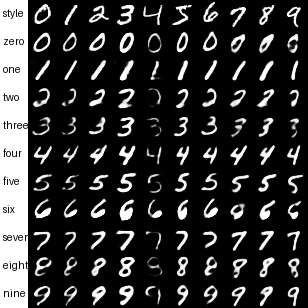

[3/100][289/937][Time 5.31]
Unified LR across all optimizers: 0.000182257351722607
=====================Train Metrics=======================
CCNet:  Three Resnet18
Inf: 0.0057	Gen: 0.1132	Rec: 0.1129	E: 0.0059	R: 0.0054	P: 0.2204

accuracy: 0.9727
precision: 0.9739
recall: 0.9711
f1_score: 0.9713

=====================Eval Metrics========================
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1_score: 1.0000



In [6]:
causal_learning.train(trainset, testset)